# 03-101 : Mlflow Experiments

### MLflow

- [mlflow.keras](https://mlflow.org/docs/1.20.0/python_api/mlflow.keras.html)
- [Keras Integration Example](https://github.com/mlflow/mlflow/blob/master/examples/keras/train.py)
- [An Experiment Tracking Tutorial with Mlflow and Keras](https://www.youtube.com/watch?v=carXIinrmOc)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import logging

import pandas as pd
import tensorflow as tf
import keras as k

from competition import source_data as sd
from competition import data_preparation as dp
from competition import feature_engineering as fe
from competition import model_data as md
from competition import model_training as mt
from competition import model_layers as ml
from competition import model_definitions as mm

import mlflow
import mlflow.keras

In [3]:
# Set the GPU memory for growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Configure Logging

In [4]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-03-22 18:43:53 INFO     Started


## Data Collection

In [5]:
# load the source training set
df_source = sd.read_csv('../data/train.csv.gz',
                        compression='gzip',
                        dtype=sd.source_dtype)

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [6]:
# load the source training labels
df_source_labels = sd.read_csv('../data/train_labels.csv')

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Data Preparation & Cleaning

In [7]:
# prepare the main dataset
df_source = dp.prepare_main_dataset(df_source,
                                    elapsed_time_min_clip=0,
                                    elapsed_time_max_clip=3691298)

# remove sessions with problems
problem_sessions = dp.find_problem_sessions(df_source)
df_source = df_source[~df_source['session_id'].isin(problem_sessions)]

In [8]:
# prepare the label dataset
df_source_labels = dp.prepare_label_dataset(df_source_labels)

# remove sessions with problems
df_source_labels = df_source_labels[~df_source_labels['session_id'].isin(problem_sessions)]

## Feature Engineering

In [9]:
# create the initial features
df_features = fe.create_initial_features(df_source, df_source_labels)

In [10]:
# add the feature to the features dataset
df_features = fe.add_elapsed_time_features(
    features=df_features,
    X=df_source)

In [11]:
# add the total count features to the features dataset
df_features = fe.add_count_total_features(
    features=df_features,
    X=df_source)

In [12]:
# add the unique count features to the features dataset
df_features = fe.add_count_unique_features(
    features=df_features,
    X=df_source)

In [13]:
# # add the screen heatmap feature to the features dataset
# df_features = fe.add_screen_heatmap_feature(df_features, df_source)

# with pd.option_context('display.max_columns', None):
#     display(df_features.head(6))

In [14]:
# display the features dataset
with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

,session_id,level_group,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode,count_total_event_name,count_total_name,count_total_fqid,count_total_room_fqid,count_total_text_fqid,count_unique_event_name,count_unique_name,count_unique_fqid,count_unique_room_fqid,count_unique_text_fqid
0,20090312431273200,0-4,0.001411,0.052535,0.000000,0.023103,0.000000,0.088782,0.088782,0.064620,0.088782,0.054054,0.75,0.000000,0.203390,0.090909,0.225
1,20090312431273200,13-22,0.043740,0.344602,0.226677,0.281804,0.301320,0.394721,0.394721,0.402262,0.394721,0.480127,0.75,0.000000,0.525424,0.545455,0.675
2,20090312431273200,5-12,0.010577,0.135014,0.060002,0.096641,0.060002,0.245951,0.245951,0.276252,0.245951,0.257552,0.75,0.000000,0.355932,0.454545,0.400
3,20090312433251036,0-4,0.001352,0.063074,0.000000,0.026311,0.000000,0.057588,0.057588,0.053312,0.057588,0.050874,1.00,0.333333,0.067797,0.000000,0.075
4,20090312433251036,13-22,0.324157,1.000000,0.318718,0.676403,1.000000,1.000000,1.000000,1.000000,1.000000,0.585056,1.00,1.000000,0.932203,0.909091,0.875
5,20090312433251036,5-12,0.021933,0.221287,0.072301,0.150206,0.072301,0.364727,0.364727,0.400646,0.364727,0.238474,1.00,0.333333,0.457627,0.454545,0.350


## Data Selection

In [15]:
random_state = 51

In [16]:
# split the dataset into train, validation and test sets
train, val, test = md.select_sessions(
    y=df_source_labels,
    random_state=random_state,
    test_size=0.60,
    train_size=0.75)

Train: 3495
Validation: 1165
Test: 6988


## Model Training

### Create Datasets

In [17]:
# set the feature list
feature_list = ['elapsed_time_sum', 'elapsed_time_max', 'elapsed_time_min', 'elapsed_time_mean', 'elapsed_time_mode']

# create the simple model dataset
simple_model_dataset = md.get_feature_dataset(
    features=df_features,
    y=df_source_labels,
    feature_list=feature_list,
    train=train,
    val=val,
    test=test,
    include_question=True,
    expand_question=False)

2023-03-22 18:44:35 INFO     -- Creating the train dataset
2023-03-22 18:44:35 INFO     ---- Creating the X dataset
2023-03-22 18:44:35 INFO     Creating the dataset for all level groups


  0%|          | 0/62910 [00:00<?, ?it/s]

2023-03-22 18:45:22 INFO     -- Creating the val dataset
2023-03-22 18:45:22 INFO     ---- Creating the X dataset
2023-03-22 18:45:22 INFO     Creating the dataset for all level groups


  0%|          | 0/20970 [00:00<?, ?it/s]

2023-03-22 18:45:37 INFO     -- Creating the test dataset
2023-03-22 18:45:37 INFO     ---- Creating the X dataset
2023-03-22 18:45:37 INFO     Creating the dataset for all level groups


  0%|          | 0/125784 [00:00<?, ?it/s]

In [18]:
print('train_X_shape:', simple_model_dataset['train']['X'].shape)
print('train_y_shape:', simple_model_dataset['train']['y'].shape)
print()

print('val_X_shape:', simple_model_dataset['val']['X'].shape)
print('val_y_shape:', simple_model_dataset['val']['y'].shape)
print()

print('test_X_shape:', simple_model_dataset['test']['X'].shape)
print('test_y_shape:', simple_model_dataset['test']['y'].shape)

train_X_shape: (62910, 23)
train_y_shape: (62910,)

val_X_shape: (20970, 23)
val_y_shape: (20970,)

test_X_shape: (125784, 23)
test_y_shape: (125784,)


In [19]:
# define the simple model input shape
input_data = simple_model_dataset['train']['X']
simple_model_shape = input_data.shape[1]
print('simple_model_shape:', simple_model_shape)

# define the output shape
output_data = simple_model_dataset['train']['y']
simple_model_output_shape = 1
print('output_shape', simple_model_output_shape)

simple_model_shape: 23
output_shape 1


### Training

#### Simple Dense

In [22]:
# configure mlflow
mlflow.set_experiment("student-performance")
mlflow.keras.autolog()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 23)]              0         
                                                                 
 dense_31 (Dense)            (None, 1024)              24576     
                                                                 
 dense_32 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_33 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 1,075,201
Trainable params: 1,075,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
 1/63 [..............................] - ETA: 44s - loss: 0.9908 - accuracy: 0.3120WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batc

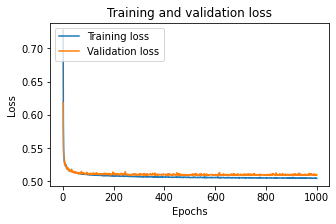

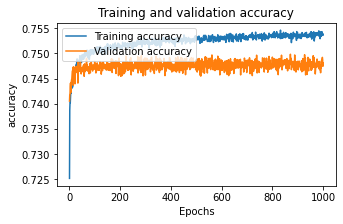

2622/2622 [==============================] - 1s 478us/step


#### Threshold: 0.5
```
              precision    recall  f1-score   support

           0       0.65      0.29      0.40     37388
           1       0.76      0.93      0.84     88396

    accuracy                           0.74    125784
   macro avg       0.70      0.61      0.62    125784
weighted avg       0.72      0.74      0.71    125784

```

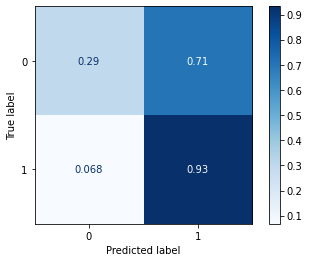

#### Optimal Threshold: 0.64
```
              precision    recall  f1-score   support

           0       0.54      0.53      0.53     37388
           1       0.80      0.81      0.80     88396

    accuracy                           0.73    125784
   macro avg       0.67      0.67      0.67    125784
weighted avg       0.72      0.73      0.72    125784

```

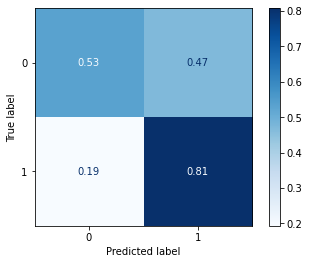

2023/03/22 19:32:21 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: tuple index out of range
2023/03/22 19:32:21 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpv5p_s_rj/model/data/model/assets
2023-03-22 19:32:21 INFO     Assets written to: /tmp/tmpv5p_s_rj/model/data/model/assets
2023-03-22 19:32:24 INFO     creating /workspaces/dsm150-2022-oct/cw02/phase_03/mlruns/317142480596307992/d4f1e74b53ed487eba383f70f5069f77/artifacts/model/data
2023-03-22 19:32:24 INFO     creating /workspaces/dsm150-2022-oct/cw02/phase_03/mlruns/317142480596307992/d4f1e74b53ed487eba383f70f5069f77/artifacts/model/data/model
2023-03-22 19:32:24 INFO     creating /workspaces/dsm150-2022-oct/cw02/phase_03/mlruns/317142480596307992/d4f1e74b53ed487eba383f70f5069f77/artifacts/model/data/model/variables
2023-03-22 19:32:24 INFO     creating /workspaces/dsm150-2022-oct/cw02/phase_03/mlruns/317142480596307992/d4f1e74b53ed487eba383f70f5069f77/artifacts/model/data/model/assets
2023-03-22 19:32:24 INFO     creating /workspaces/dsm150-2022-oct/cw02/phase_03/mlruns/317142480596307992/d4f1e74b53ed487eba383f70f5069f77/artifacts/tensorboard

In [36]:
# log the parameters
mlflow.set_tag('model', 'simple-dense-model')
mlflow.set_tag('notebook', '03-101_mlflow.ipynb')
mt.log_params(simple_model_dataset, feature_list, random_state)

# train the model
model = mm.train_simple_dense(
    dataset=simple_model_dataset,
    input_shape=simple_model_shape,
    output_shape=simple_model_output_shape,
    dense_layer_count=2,
    dense_units=1024,
    dense_activation='relu',
    dense_l1_regulization=1e-5,
    dense_l2_regulization=0.0,
    dense_dropout=0.0,
    train_epochs=1000,
    train_batch_size=1000,
    train_optimizer='adam',
    train_loss='binary_crossentropy',
    train_metrics=['accuracy'],
    train_class_weight=None)

mlflow.end_run()